In [27]:
import torch
import pandas as pd
import os
from PIL import Image
import numpy as np
from torch.amp import autocast
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time
import torchvision.transforms as v2
from collections import Counter
import random
from sklearn.metrics import confusion_matrix
#Fix for h5py sometimes not being able to open files in parallel
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py

class networkTraining():
    """Class for training and testing a neural network model.
    This class handles the training and testing process, including saving the model.
    """
    def __init__(self, model, optimizer, criterion):
        """Creates the network training class.
        This class handles the training and testing process, including saving the model.

        Args:
            model: Model to be trained.
            optimizer: Optimizer to be used.
            criterion: Loss function to be used.
        """
        self.device_type = get_device()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = torch.device(self.device_type)
        self.model.to(self.device, non_blocking=True)
        self.history = {}

    #Adapted fromkuzu_main.py, hw1 of COMP9444
    def train(self, train_loader: DataLoader, epoch:int=0, name:str="train"):
        """Trains the model for one epoch using the given data loader. Epoch is used for logging purposes.

        Args:
            train_loader (DataLoader): DataLoader for the training data.
            epoch (int, optional): Epoch of the cycle. Used for logging. Defaults to 0.
        """
        self.model.train()
        correct = 0
        loss_total = 0
        total_images = 0

        t = time.time()
        conf_matrix = np.zeros((3, 3))

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            target = target.long()
            self.optimizer.zero_grad()

            with autocast(device_type=self.device_type):
                outputs = self.model(data)
                loss = self.criterion(outputs, target)
            loss.backward()
            self.optimizer.step()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss_total += loss.item()

            total_images += len(data)

            conf_matrix += confusion_matrix(target.cpu(), pred.cpu())

            #print(f"Train Epoch: {epoch} [{total_images}/{len(train_loader.dataset)}]")

        self.history.setdefault(epoch, {})[f"{name}_loss"] = loss_total / (batch_idx+1)
        self.history[epoch][f"{name}_accuracy"] = correct / len(train_loader.dataset)
        self.history[epoch][f"{name}_time"] = time.time() - t
        print(f"Train Epoch: {epoch}\t Loss: {loss_total / (batch_idx+1):.6f} \t Accuracy: {correct}/{len(train_loader.dataset)} ({correct / len(train_loader.dataset):.2%})")
        print(f"Confusion matrix for train:")
        print(conf_matrix)

    #Adapted fromkuzu_main.py, hw1 of COMP9444
    def test(self, test_loader: DataLoader, name:str="test", epoch:int=0):
        """Tests the model using the given data loader. Name is used for logging purposes.

        Args:
            train_loader (DataLoader): DataLoader for the training data.
            name (str, optional): Name of the test set. Used for logging. Defaults to "Test".
        """
        self.model.eval()

        test_loss = 0
        correct = 0
        total_samples = 0
        batches = len(test_loader)

        t = time.time()

        #inference_mode is faster than no_grad
        with torch.inference_mode():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                with autocast(self.device_type):
                    outputs = self.model(data)
                    target = target.long()
                    loss = self.criterion(outputs, target)

                test_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == target).sum().item()
                total_samples += target.size(0)

        self.history.setdefault(epoch, {})[f"{name}_loss"] = test_loss / (batches)
        self.history[epoch][f"{name}_accuracy"] = correct / len(test_loader.dataset)
        self.history[epoch][f"{name}_time"] = time.time() - t

        print(f"\n{name}: Average loss: {test_loss / batches:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({correct / len(test_loader.dataset):.2%}%)\n")

        #Confusion matrix
        conf_matrix = confusion_matrix(target.cpu(), pred.cpu())
        print(f"Confusion matrix for {name}:")
        print(conf_matrix)

        return correct / (len(test_loader.dataset))


    def save_model(self, path, model_name="history/model"):
        #Save the model
        torch.save(self.model.state_dict(), path)

        #Save the history of the model
        df = pd.DataFrame(self.history).T
        df = df.rename_axis('epoch').reset_index()
        #Create the folder if it does not exist
        os.makedirs(os.path.dirname(model_name), exist_ok=True)
        df.to_csv(f"{model_name}_history.csv", index=False)

    def plot_model(self, path='plot.jpg', model_name="model"):
        df = pd.DataFrame(self.history).T
        df = df.rename_axis("epoch").reset_index()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        #Loss and accuracy
        loss_list = [x for x in list(df) if "loss" in x]
        acc_list = [x for x in list(df) if "accuracy" in x]

        for loss in loss_list:
            ax[0].plot(df["epoch"], df[loss], label=loss)

        for acc in acc_list:
            ax[1].plot(df["epoch"], df[acc], label=acc)

        #Labelling and formatting
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].set_title("Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
        ax[1].set_ylim((0, 1))
        ax[1].legend()

        fig.tight_layout()
        fig.subplots_adjust(top=0.9)

        #Title
        fig.suptitle(f"{model_name} Performance")
        plt.savefig(path)

        plt.show()

def get_device():
    """Finds the device to be used for training and testing.
    This is used to determine if a GPU is available.
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'

    return 'cpu'

MELANOMA = 1
NEITHER = 0
SEB = 2
def create_h5_from_images(csv_path: str, img_dir: str, h5_filename: str, resolution=(224, 224)):
    """Creates an HDF5 file from a CSV file containing images and their labels.
    Images are stored in uint8 format, where the images are (height, width, channels).
    The labels are stored as int.

    Args:
        csv_path (str): Path to the CSV file containing image IDs and labels in the form of 'image_id,truth'.
        img_dir (str): Relative path to the directory containing the images.
        h5_filename (str): Relative path to the output HDF5 file.
        resolution (tuple, optional): Height and width of output images. Defaults to (224, 224).
    """
    df = pd.read_csv(csv_path)
    num_samples = len(df)

    with h5py.File(h5_filename, 'w', locking=False) as f:
        image_width, image_height = resolution
        #Metadata
        f.attrs['resolution'] = (image_width, image_height)
        f.attrs['num_samples'] = num_samples
        f.attrs['num_classes'] = len(df['truth'].unique())


        #Dataset of images and labels
        dset_images = f.create_dataset("images",
                                       shape=(num_samples, image_height, image_width, 3),
                                       dtype=np.uint8)

        dset_labels = f.create_dataset("labels", shape=(num_samples,), dtype=np.uint8)

        for i, row in df.iterrows():
            img_id = row['image_id']
            label  = row['truth']  # Labelling
            img_path = os.path.join(img_dir, f"{img_id}.jpg")

            #Resize
            with Image.open(img_path).convert('RGB') as img:
                transform = v2.Compose([
                    v2.Resize(size=(image_height, image_width)),
                    #v2.CenterCrop(size=(image_height, image_width)),
                ])
                img = transform(img)
                # Convert to NumPy array
                img_np = np.array(img, dtype=np.uint8)

            dset_images[i] = img_np
            dset_labels[i] = label

            if i % 200 == 0:
                print(f"Processed {i}/{len(df['truth'])} images")

    print(f"Created {h5_filename} with {num_samples} samples.")

class HDF5Dataset(torch.utils.data.Dataset):
    """HDF5 dataset class for loading images and labels from an HDF5 file.
    """
    def __init__(self, filepath: str, transform:str=None):
        """Create a pytorch dataset from an HDF5 file containing images and labels.
        The images are stored in uint8 format, where the images are (height, width, channels).
        The labels are stored as int.
        The dataset is read-only and the file is closed after reading.

        Args:
            filepath (str): Relative path to the HDF5 file.
            transform (str, optional): Transformation of the dataset if required. Defaults to None.
        """
        super().__init__()
        self.filepath = filepath
        self.transform = transform

        with h5py.File(filepath, 'r') as f:
            self.images = f['images'][:]
            self.labels = f['labels'][:]
            self.length = len(self.labels)
            self.all_labels = np.array(f['labels'], dtype=np.uint8)
            try:
                self.resolution = f.attrs['size']
            except KeyError:
                self.resolution = (self.images.shape[1], self.images.shape[2])

        self.classes = np.unique(self.all_labels)

        self.file = None # Initialize file to None

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        #Allows for each worker to open the file independently
        if self.file is None:
            self.file = h5py.File(self.filepath, 'r')

        image = self.file['images'][idx]
        label = self.file['labels'][idx]

        image = Image.fromarray(image, 'RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def save_transformed_image(tensor, filename, output_dir="transformed_images"):
    #Saves a transformed image tensor to a file.
    os.makedirs(output_dir, exist_ok=True)
    # Add back the mean and std if you want to visualize the original color space
    mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)[:, None, None]
    std = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)[:, None, None]
    img = tensor * std + mean
    img = img.clamp(0, 1)
    img = Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    filepath = os.path.join(output_dir, filename)
    img.save(filepath)

def add_truth_column(raw: str, modified: str):
    """Given a csv file with image_id and labels, add a column for truth values.
    0 - neither melanoma nor seb
    1 - melanoma
    2 - seborrheic keratosis

    Args:
        raw (str): Path to the raw csv file with image_id and labels.
        modified (str): Path to the modified csv file with image_id and truth values.
    """

    df = pd.read_csv(raw)
    output_file = modified
    print(df.shape)
    df.insert(len(df.columns), "truth", NEITHER)
    for index, row in df.iterrows():
        #intially truth is 0
        # assign melanoma as 1
        if row['melanoma'] == 1.0 :
            df.at[index, 'truth'] = MELANOMA
        # assign seb as 2
        elif row['seborrheic_keratosis'] == 1.0 :
            df.at[index, 'truth'] = SEB

    df.to_csv(output_file)

def print_label_distribution(h5_file_path):
    with h5py.File(h5_file_path, 'r') as f:
        labels = f['labels'][:]
        unique_labels, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique_labels, counts):
            print(f"Label {label}: {count} samples")
    return 0

def count_samples(dataloader):
    labels = np.concatenate([labels.numpy() for _, labels in dataloader])
    return Counter(labels)

def seed_program(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

def convertdata():
    #Example usage of dataset creation
    add_truth_column("data/train.csv", "data/train_truth_1.csv")
    add_truth_column("data/validation.csv", "data/validation_truth.csv")
    add_truth_column("data/test.csv", "data/test_truth_1.csv")
    create_h5_from_images("data/train_truth_1.csv", "data/train", "data/train.h5", (128, 128))
    create_h5_from_images("data/validation_truth.csv", "data/validation", "data/valid.h5", (128, 128))
    create_h5_from_images("data/test_truth_1.csv", "data/test", "data/test.h5", (128, 128))

    #We can see the distribution of the labels in the dataset
    print_label_distribution("data/train.h5")
    print_label_distribution("data/valid.h5")
    print_label_distribution("data/test.h5")

In [21]:
from torchvision import models
import torch.nn as nn

def MobileNetV3Model(num_classes=3):
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
    #Freeze the layers
    for param in model.parameters():
        param.requires_grad = False
    # Change the last layer to match the number of classes
    in_features = 960
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 120),
        nn.BatchNorm1d(120),
        nn.ReLU(),
        nn.Linear(120, 85),
        nn.BatchNorm1d(85),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(85, num_classes)
    )
    return model

def AlexNetModel(num_classes=3):
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    #Freeze the layers
    for param in model.parameters():
        param.requires_grad = False
    # Change the last layer to match the number of classes
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 120),
        nn.BatchNorm1d(120),
        nn.ReLU(),
        nn.Linear(120, 85),
        nn.BatchNorm1d(85),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(85, num_classes)
    )

    return model

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Transforms
Data size:  2750
Class counts:  [1843  386  521]
Data loading
Train size:  2337 Counter({np.uint8(0): 1566, np.uint8(2): 443, np.uint8(1): 328})
Valid size:  413 Counter({np.uint8(0): 277, np.uint8(2): 78, np.uint8(1): 58})
Training epoch:  0
Train Epoch: 0	 Loss: 1.053698 	 Accuracy: 1013/2337 (43.35%)
Confusion matrix for train:
[[117. 276. 384.]
 [ 61. 449. 271.]
 [105. 227. 447.]]
Testing epoch:  0

Validation: Average loss: 1.0713, Accuracy: 122/413 (29.54%%)

Confusion matrix for Validation:
[[ 63  15 199]
 [ 13  10  35]
 [ 19  10  49]]
New best accuracy: 0.29539951573849876
Training epoch:  1
Train Epoch: 1	 Loss: 0.918466 	 Accuracy: 1316/2337 (56.31%)
Confusion matrix for train:
[[253. 218. 310.]
 [ 63. 578. 156.]
 [ 95. 179. 485.]]
Testing epoch:  1

Validation: Average loss: 0.9887, Accuracy: 225/413 (54.48%%)

Confusion matrix for Validation:
[[176  40  61]
 [ 25  30   3]
 [ 43  16  19]]
New best accuracy: 0.5447941888619855
Training epoch:  2
Train Epoch: 2	 Los

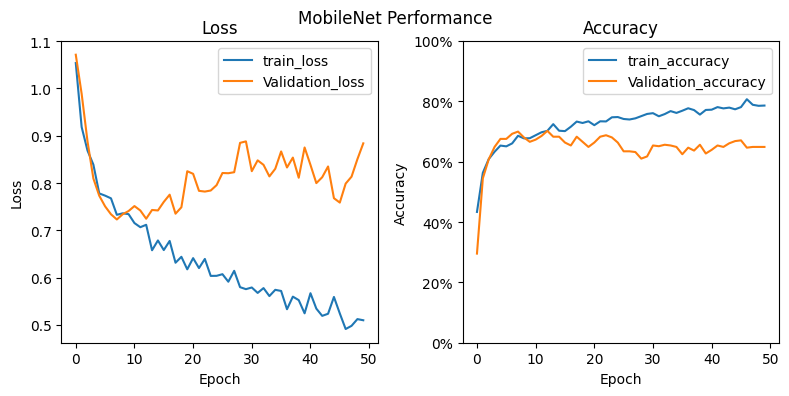

0.7021791767554479


In [22]:
import torch
import numpy as np
from torchvision.transforms import v2
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
from sklearn.model_selection import train_test_split
from collections import Counter

#Set the seed for reproducibility
seed_program(seed=1)

#0.1 Data preprocessing variables
image_scale = (224, 224)

mean_vars = [0.485, 0.456, 0.406]
std_vars = [0.229, 0.224, 0.225]

transforms_2017 = v2.Compose([
    v2.Resize(image_scale),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean_vars, std=std_vars),
    v2.ToTensor()
])


transforms_train = v2.Compose([
    v2.RandomResizedCrop(scale=(0.8, 1.0), size=image_scale,ratio=(0.9, 1.1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=45),

    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean_vars, std=std_vars),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
])

print("Transforms")
batch_size = 256

#Read Data
data_name = "data/all_224.h5"
data = HDF5Dataset(data_name)
print("Data size: ", len(data))
#Print class breakdown
class_counts = np.bincount(data.all_labels)
print("Class counts: ", class_counts)

#Train, test, valid split via stratified sampling
#2000, 550, 200
train_idx, valid_idx, train_label, _ = train_test_split(
    np.arange(len(data.all_labels)), data.all_labels, stratify=data.all_labels, test_size=0.15, random_state=42
)
print("Data loading")
train_dataset = HDF5Dataset(data_name, transform=transforms_train)
valid_dataset = HDF5Dataset(data_name, transform=transforms_2017)

train_data = torch.utils.data.Subset(train_dataset, train_idx)
valid_data = torch.utils.data.Subset(valid_dataset, valid_idx)

class_weights = 1.0 / class_counts
weights = class_weights[train_data.dataset.all_labels[train_data.indices]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

#Sizes of the datasets
print("Train size: ", len(train_data), Counter(train_data.dataset.all_labels[train_data.indices]))
print("Valid size: ", len(valid_data), Counter(valid_data.dataset.all_labels[valid_data.indices]))

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    sampler=sampler,
    shuffle = False,
    num_workers=12,
    pin_memory=True
)

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=len(valid_data),
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

#Testing the data loading. This is SLOW, so only run to verify the data loading is correct.
if 0 == 1:
    print("After loading data:")
    print(f"Train: {count_samples(train_loader)}")
    print(f"Valid: {count_samples(valid_loader)}")

    exit()

#2. Hyperparameters, standard for reference
learning_rate = 3e-4
num_epochs = 50
weight_decay = 1e-4

#3. Model
#model = AlexNetModel(num_classes=3)
model = MobileNetV3Model(num_classes=3)
#4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
name = "mobilenet"
accuracy = 0
best_accuracy = 0
best_model = None

#5. Training and testing
trainer = networkTraining(model, optimizer, criterion)
for epoch in range(num_epochs):
    print("Training epoch: ", epoch)
    trainer.train(train_loader, epoch)

    print("Testing epoch: ", epoch)
    accuracy = max(accuracy, trainer.test(valid_loader, "Validation", epoch))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_file = f"models/{name}_{epoch}.pth"
        best_epoch = epoch
        print(f"New best accuracy: {best_accuracy}")
        #Save the model
        trainer.save_model(f"models/{name}_{epoch}.pth", model_name=f"history/{name}")

#Save the model after final testing
trainer.save_model(f"models/{name}_{num_epochs}.pth", model_name=f"history/{name}")

trainer.plot_model(model_name="MobileNet", path=f"plots/{name}.jpg")
print(accuracy)

In [25]:
device = trainer.device
BEST_MODEL_PATH = best_model_file

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)

trainer.model.load_state_dict(state_dict)

trainer.test(valid_loader, "Validation FT", best_epoch)


Valid: Average loss: 0.6206, Accuracy: 311/413 (75.30%%)

Confusion matrix for Valid:
[[227  18  32]
 [ 10  46   2]
 [ 29  11  38]]


0.7530266343825666

Switched to new optimizer with LR: 0.0001

Validation: Average loss: 0.6206, Accuracy: 311/413 (75.30%%)

Confusion matrix for Validation:
[[227  18  32]
 [ 10  46   2]
 [ 29  11  38]]
Fine-tuning epoch: 27
Train Epoch: 27	 Loss: 0.395857 	 Accuracy: 2026/2337 (86.69%)
Confusion matrix for train:
[[656.  49. 113.]
 [ 24. 719.  14.]
 [104.   7. 651.]]
Validating fine-tuning epoch: 27

Validation FT: Average loss: 0.6428, Accuracy: 305/413 (73.85%%)

Confusion matrix for Validation FT:
[[225  17  35]
 [ 12  43   3]
 [ 27  14  37]]
Fine-tuning epoch: 28
Train Epoch: 28	 Loss: 0.355499 	 Accuracy: 2053/2337 (87.85%)
Confusion matrix for train:
[[646.  44. 117.]
 [ 17. 701.  11.]
 [ 80.  15. 706.]]
Validating fine-tuning epoch: 28

Validation FT: Average loss: 0.6570, Accuracy: 306/413 (74.09%%)

Confusion matrix for Validation FT:
[[219  20  38]
 [  9  46   3]
 [ 23  14  41]]
Fine-tuning epoch: 29
Train Epoch: 29	 Loss: 0.344859 	 Accuracy: 2059/2337 (88.10%)
Confusion matrix for train:
[[

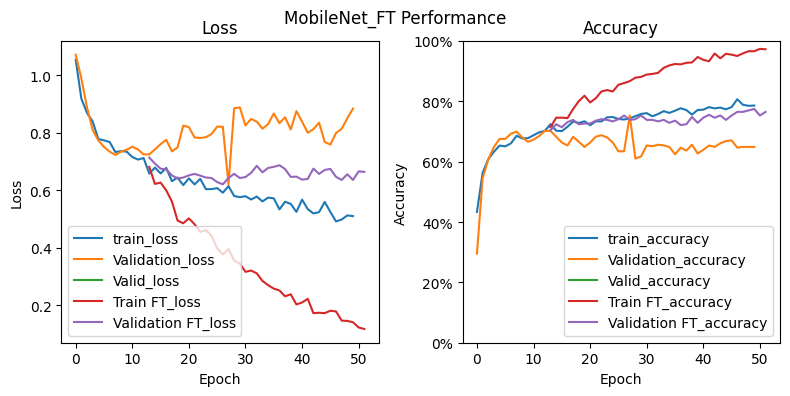

In [26]:

for param in trainer.model.parameters(): # Access model via trainer
    param.requires_grad = True

learning_rate_finetune = 1e-4

optimizer_finetune = torch.optim.AdamW(trainer.model.parameters(), lr=learning_rate_finetune, weight_decay=weight_decay)

# Update the optimizer within the trainer object
trainer.optimizer = optimizer_finetune
print(f"Switched to new optimizer with LR: {learning_rate_finetune}")

# 3. Continue training for a few more epochs
num_finetune_epochs = 25 # Example: Train for 15 more epochs
start_finetune_epoch = best_epoch+1 # Continue epoch numbering for logging

trainer.test(valid_loader, "Validation", start_finetune_epoch)

for epoch in range(start_finetune_epoch, start_finetune_epoch + num_finetune_epochs):
    print(f"Fine-tuning epoch: {epoch}")
    # Use the same training method, it will now use the new optimizer
    trainer.train(train_loader, epoch, name=f"Train FT")

    print(f"Validating fine-tuning epoch: {epoch}")
    val_acc = trainer.test(valid_loader, "Validation FT", epoch)

    trainer.save_model(f"models/{name}_{epoch}_ft.pth", model_name=f"history/{name}_ft")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_file = f"models/{name}_{epoch}_ft.pth"
        best_epoch = epoch
        print(f"New best accuracy: {best_accuracy}")

print(f"\nTraining finished. Best overall validation accuracy: {best_epoch}, {best_accuracy:.2%}")

trainer.plot_model(model_name="MobileNet_FT", path=f"plots/{name}_ft.jpg")

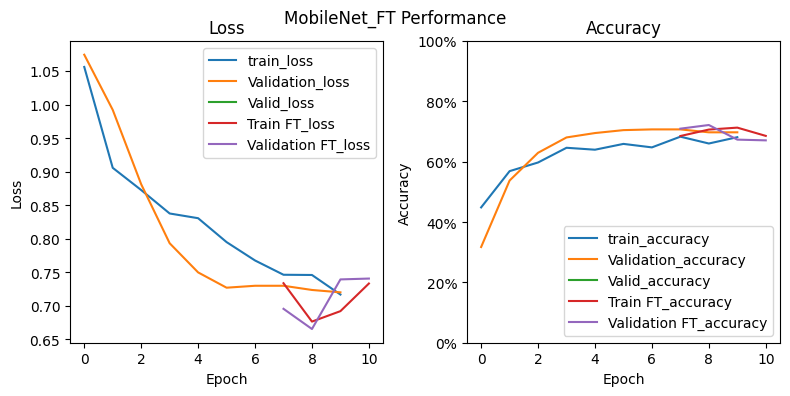

In [16]:
trainer.plot_model(model_name="MobileNet_FT", path=f"plots/{name}_ft.jpg")